In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
AMDdata = pd.read_csv("AMD.csv")
NVDAdata = pd.read_csv("NVDA.csv")
INTCdata = pd.read_csv("INTC.csv")
data = AMDdata       
openclose_difference = data['Open'] - data['Close']
highlow_difference = data['High'] - data['Low']
volume = data['Volume']

# normalize volume with softmax
def normalize(inputs):
    normal = lambda x: (x-min(inputs))/(max(inputs)-min(inputs))
    return normal(inputs)

features = [data["Close"],openclose_difference, highlow_difference, normalize(data['Volume'])]
feature_length = len(features)
feature_width = 25
dataset = np.array(features)
dataset = np.transpose(dataset)
r = 0.2
train_features = 600
test_features = 150
split = int(r * len(dataset))
remainder = (len(data)-split) % train_features
train_data = dataset[split:-remainder]
test_data = dataset[:split]
train_close_data = np.array([data['Close'][split:-remainder]])
test_close_data = np.array([data["Close"][:split]])


In [60]:

import tensorflow as tf
import tensorflow.keras as ks

train_dataset_x = tf.constant(np.reshape(train_data, (int(train_features/feature_width),feature_width,feature_length))[1:])
train_dataset_y = tf.constant(np.roll(np.reshape(train_close_data, (int(train_features/feature_width),feature_width)),1,0)[1:]) # reshape and shift right

test_dataset_x = tf.constant(np.reshape(test_data, (int(test_features/feature_width),feature_width,feature_length))[1:])
test_dataset_y = tf.constant(np.roll(np.reshape(test_close_data, (int(test_features/feature_width),feature_width)),1,0)[1:])

model = ks.Sequential([
    tf.keras.layers.LSTM(250, return_sequences=False),
    tf.keras.layers.Dense(200),
    tf.keras.layers.Dense(feature_width)
])
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            1e-3,
            decay_steps=1000,
            decay_rate=0.98,
            staircase=True)

model.compile(
            optimizer="rmsprop",
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=['accuracy'])

model.fit(train_dataset_x,train_dataset_y, epochs=200, workers=2, validation_split=0.25)



Epoch 1/200
1/1 [==============================] - 12s 12s/step - loss: 10166.8389 - accuracy: 0.0000e+00 - val_loss: 11067.4072 - val_accuracy: 0.1667
Epoch 2/200
1/1 [==============================] - 0s 78ms/step - loss: 9954.6797 - accuracy: 0.1765 - val_loss: 10855.8750 - val_accuracy: 0.1667
Epoch 3/200
1/1 [==============================] - 0s 80ms/step - loss: 9748.9082 - accuracy: 0.0588 - val_loss: 10566.1846 - val_accuracy: 0.1667
Epoch 4/200
1/1 [==============================] - 0s 81ms/step - loss: 9460.2578 - accuracy: 0.1765 - val_loss: 10169.2490 - val_accuracy: 0.1667
Epoch 5/200
1/1 [==============================] - 0s 79ms/step - loss: 9066.6279 - accuracy: 0.1765 - val_loss: 9635.8691 - val_accuracy: 0.1667
Epoch 6/200
1/1 [==============================] - 0s 84ms/step - loss: 8533.9814 - accuracy: 0.1765 - val_loss: 8933.1377 - val_accuracy: 0.1667
Epoch 7/200
1/1 [==============================] - 0s 92ms/step - loss: 7845.5176 - accuracy: 0.1765 - val_loss: 80

1/1 [==============================] - 1s 704ms/step



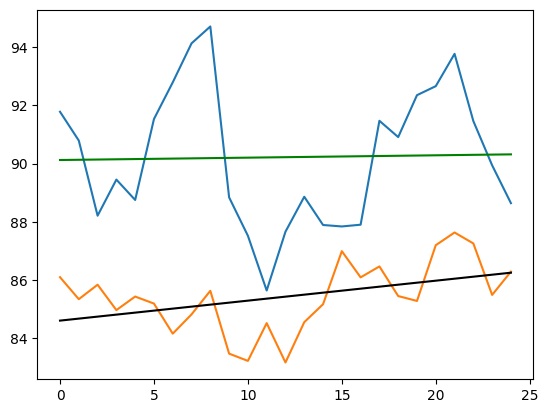

0.0685812143179087
0.00808468615384529
buy


In [61]:
test_index = 1
test = np.reshape(test_dataset_x[test_index], (1,feature_width,feature_length))
prediction = model.predict(test)[0]
domain_test = range(feature_width)

# eliminate outliers
filtered = []
filtered_domain = list(range(len(prediction)))
for i in range(len(prediction)):
    if(prediction[i] >= min(test_dataset_y[test_index]) and prediction[i] <= max(test_dataset_y[test_index])):
        filtered.append(prediction[i])
    else: 
        filtered_domain.remove(i)
plt.close()
filtered = prediction
filtered_domain = domain_test
from pprint import pprint
from sympy import Matrix

# fit solution data
b = Matrix([test_dataset_y[test_index]]).transpose()
At = Matrix([domain_test,np.ones((len(domain_test)))])
A = At.transpose()
AtA = At*A
Atb = At*b

augmented = AtA.row_join(Atb)
solutions = augmented.rref()
s = list(solutions[0][:,2].transpose())
s0 = s[0]; s1 = s[1]
def fs(x): return x*s0 + s1

b = Matrix([filtered]).transpose()
At = Matrix([range(len(filtered)),np.ones((len(filtered)))])
A = At.transpose()
AtA = At*A
Atb = At*b

augmented = AtA.row_join(Atb)
solutions = augmented.rref()

x = list(solutions[0][:,2].transpose())
a0 = x[0]; a1 = x[1]
print()
def fp(x): return x*a0 + a1
def fp_match(x): return x*a0 + fs(0)

plt.plot(domain_test, test_dataset_y[test_index])
plt.plot(filtered_domain, filtered)
plt.plot(domain_test, list(map(fp,domain_test)), color='black')
plt.plot(domain_test, list(map(fs,domain_test)), color='green')

plt.show()
plt.close()
print(a0)
print(s0)

if(a0 > 0.025) : print("buy")
if(a0 < 0.025 and a0 > -0.05): print("hold")
if(a0 < -0.25): print("sell")